# Advanced usage

The standard functionality of the `sensemakr` module, demonstrated in the previous section, will suﬃce for most users, most of the time. When needed, more ﬂexibility can be obtained by employing the sensitivity functions of the package directly, such as: (i) functions for sensitivity plots (`ovb_contour_plot`, `ovb_extreme_plot`); (ii) functions for computing bias-adjusted estimates and t-values (`adjusted_estimate`, `adjusted_t`); (iii) functions for computing the robustness value and partial R2 directly (`robustness_value`, `partial_r2`); and, (iv) functions for bounding the strength of unobserved confounders (`ovb_bounds`), among others. These functions are in the modules `ovb_plots`, `bias_functions`, `sensitivity_stats`, and `ovb_bounds`. 

In this notebook we demonstrate how to use these modules in two examples.

## The risks of informal benchmarking

Informal "benchmarking" procedures have been widely suggested in the sensitivity analysis literature as a means to aid interpretation. It intends to describe how an unobserved confounder $Z$ "not unlike" some observed covariate $X_j$ would alter the results of a study. [Cinelli and Hazlett (2020)](https://doi.org/10.1111/rssb.12348) show why these proposals may lead users to erroneous conclusions, and offer formal bounds on the bias that could be produced by unobserved confounding "as strong" as certain observed covariates. 

Here we use `sensemakr` to replicate the example in Section 6.1 of [Cinelli and Hazlett (2020)](https://doi.org/10.1111/rssb.12348). This example provides a useful tutorial on how users can construct their own sensitivity contour plots with customized bounds, beyond what is offered by default on the package.

### Simulating the data

We begin by simulating the data generating process used in our example. Consider a treatment variable $D$, an outcome variable $Y$, one observed confounder $X$, and one *unobserved* confounder $Z$. Again, all disturbance variables $U$ are standardized mutually independent gaussians, and note that, in reality, the treatment $D$ has *no causal effect* on the outcome $Y$. 

\begin{align}
Z &= U_{z}\\
X &= U_{x}\\
D &= X + Z + U_d\\
Y &= X + Z + U_y
\end{align}

Also note that, in this model: (i) the unobserved confounder $Z$ is independent of $X$; and, (ii) the unobserved confounder $Z$ is *exactly like* $X$ in terms of its strength of association with the treatment and the outcome. The code below creates a sample of size 100 of this data generating process. We make sure to create residuals that are standardized and orthogonal so that all properties that we describe here will hold exactly even in this finite sample.

In [1]:
# imports statsmodels, numpy, and pands
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# defines function to simulate orthogonal residuals
def resid_maker(n,df):
    N = np.random.normal(0,1,n)
    form = 'N~' +'+'.join(df.columns)
    df['N'] = N
    model = smf.ols(formula=form,data=df).fit()
    e = model.resid
    e = (e-np.mean(e))/np.std(e)
    return(e)

# simulates data
n = 100
X = np.random.normal(0,1,n)
X = (X - np.mean(X))/np.std(X)
Z = resid_maker(n,pd.DataFrame({'x':X}))
D = X + Z + resid_maker(n,pd.DataFrame({'x':X,'z':Z}))
Y = X + Z + resid_maker(n,pd.DataFrame({'x':X,'z':Z,'d':D}))

### Fitting the model

In this example, the investigator does not observe the confounder $Z$. Therefore, she is forced to fit the restricted linear model $Y \sim D + X$, resulting in the following estimated values


In [2]:
# creates data.frame with the data
df = pd.DataFrame({'Y':Y,'X':X,'Z':Z,'D':D})

# runs OLS
model_ydx = smf.ols(formula='Y~D+X',data=df).fit()

# prints OLS summary
model_ydx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     48.50
Date:                Wed, 29 Dec 2021   Prob (F-statistic):           2.51e-15
Time:                        18:03:39   Log-Likelihood:                -162.17
No. Observations:                 100   AIC:                             330.3
Df Residuals:                      97   BIC:                             338.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.776e-17      0.124   2.23e-16      1.000      -0.247       0.247
D              0.5000      0.088      5.686      0.000       0.325       0.675
X              0.5000      0.152      3.283      0.001       0.198       0.802
==============================================================================
Omnibus:                        5.219   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                4.552
Skew:                          -0.474   Prob(JB):                        0.103
Kurtosis:                       3.438   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note we obtain a large and statistically significant coefficient estimate of the effect of $X$ on $Y$ ($0.5$). However, we know that the variable $Z$ is not observed, and there is the fear that this estimated effect is in fact due to the bias caused by $Z$. On the other hand, let us suppose the investigator correctly knows that: (i) $Z$ and $X$ have the same strength of association with $D$ and $Y$; and, (ii) $Z$ is independent of $X$. Can we leverage this information to understand how much bias a confounder $Z$ "not unlike" $X$ could cause?

### Informal benchmarks

Computing the bias due to the omission of $Z$ requires two sensitivity parameters: its partial $R^2$ with the treatment $D$ and its partial $R^2$ with the outcome $Y$. How could we go about computing the bias that a confounder $Z$ "not unlike $X$" would cause? 

Intuitively, it seems that we could take as reference the observed partial $R^2$ of $X$ with $D$ and $Y$, and use those as the plausible values for the sensitivity parameters. So let us now compute those observed partial $R^2$ using the `partial_r2()` function of the module `sensitivity_stats`. For the partial $R^2$ of $X$ with the treatment, we also need to fit a treatment regression $D \sim X$ first.

In [3]:
# loads sensitivity_stats module
from sensemakr import sensitivity_stats

# fits treatment regression
model_dx=smf.ols(formula='D~X',data=df).fit()

# computes observed partial R2 of X with D and Y
r2dx   = sensitivity_stats.partial_r2(model_dx,  covariates='X')
r2yx_d = sensitivity_stats.partial_r2(model_ydx, covariates='X')

Once both partial $R^2$ are computed, we can determine the implied adjusted estimate due to an unobserved confounder $Z$ using the `adjusted_estimate()` function of the `bias_functions` module. 

In [4]:
# loads bias_functions module
from sensemakr import bias_functions

# computes adjusted estimate
informal_adjusted_estimate = bias_functions.adjusted_estimate(model    = model_ydx,
                                                             treatment = "D",
                                                             r2dz_x    = r2dx,
                                                             r2yz_dx   = r2yx_d)

We can now plot the sensitivity contours with `ovb_contour_plot()` and add our informal benchmark with `add_bound_to_contour()` from the `ovb_plots` module.

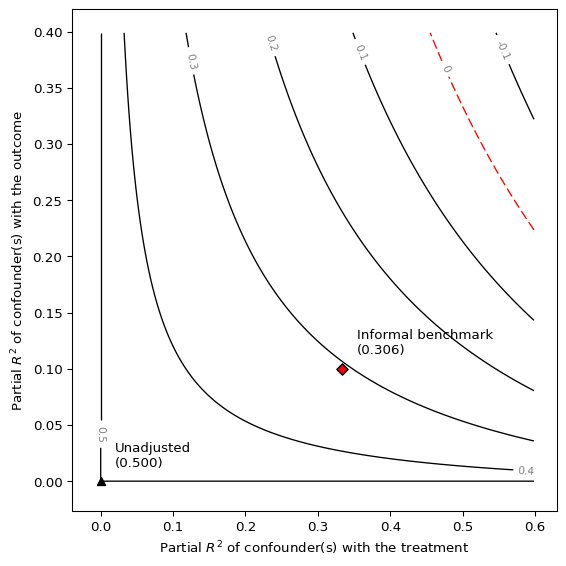

In [5]:
# loads ovb_plots module
from sensemakr import ovb_plots

# draws sensitivity contours
ovb_plots.ovb_contour_plot(model = model_ydx, treatment = "D", lim = 0.6)

# adds informal benchmark
ovb_plots.add_bound_to_contour(r2dz_x     = r2dx,
                              r2yz_dx     = r2yx_d,
                              bound_value = informal_adjusted_estimate,
                              bound_label = 'Informal benchmark')

As we can see, the results of the informal benchmark are different from what we expected. The informal benchmark point is still far away from zero, and this would lead an investigator to incorrectly conclude that an unobserved confounder $Z$ "not unlike $X$" is not sufficient to explain away the observed effect. Moreover, this incorrect conclusion occurs despite *correctly* assuming that: (i) $Z$ and $X$ have the same strength of association with $D$ and $Y$; and, (ii) $Z$ is independent of $X$. See Section 6.1 of [Cinelli and Hazlett (2020)](https://doi.org/10.1111/rssb.12348) for details of why this happens.

### Formal bounds

We now show how to compute formal bounds using the function `ovb_bounds()` of the `ovb_bounds` module.

In [6]:
# loads ovb_bounds module
from sensemakr import ovb_bounds

# computes formal bounds
formal_bound = ovb_bounds.ovb_bounds(model = model_ydx,
                                     treatment = 'D',
                                     benchmark_covariates = "X", 
                                     kd = 1, 
                                     ky = 1)

In this function we specify the linear model being used (`model.ydx`), the treatment of interest ($D$), the observed variable used for benchmarking ($X$), and how stronger $Z$ is in explaining treatment (`kd`) and outcome (`ky`) variation, as compared to the benchmark variable $X$. We can now plot the proper bound against the informal benchmark.

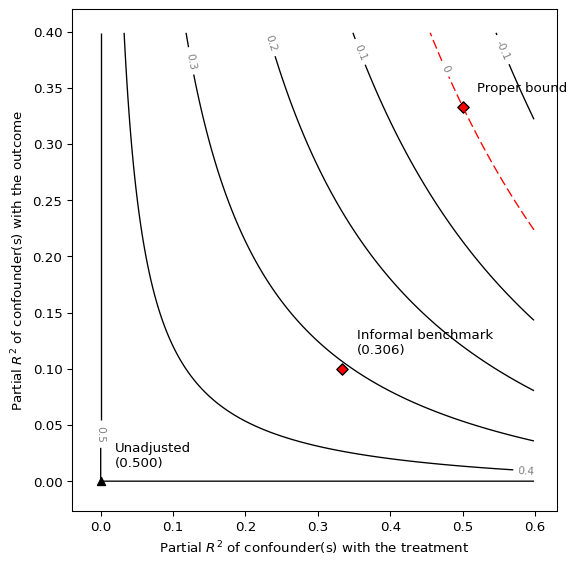

In [7]:
# contour plot contrasting informal vs formal bounds

ovb_plots.ovb_contour_plot(model=model_ydx,treatment="D",lim=0.6)

ovb_plots.add_bound_to_contour(r2dz_x  = r2dx,
                               r2yz_dx = r2yx_d,
                               bound_value = informal_adjusted_estimate,
                               bound_label = 'Informal benchmark')

ovb_plots.add_bound_to_contour(bounds     = formal_bound,
                               bound_label= 'Proper bound')

Note that, using the formal bounds, the researcher now reaches the correct conclusion that, an unobserved confounder $Z$ similar to $X$ is strong enough to explain away all the observed association.

## Manually providing input data

We now demonstrate how to replicate the sensitivity analysis of the Darfur example (see Quickstart) without access to the microdata, using only usual statistics found in the regression tables. All results of the Darfur example, except the formal benchmark bounds as we explaim below, can be recoverded by simply providing: (i) the point estimate of `directlyharmed` ($0.097$); (ii) its estimated standard error ($0.023$); and, (ii) the degrees of freedom of the regression ($783$). This type of "manual" analysis can be useful when reading or reviewing papers that did not perform sensitivity.

In [8]:
# computes the robustness value
sensitivity_stats.robustness_value(t_statistic = 0.097/0.023, dof = 783)

0    0.139787
dtype: float64

In [9]:
# computes the partial R2
sensitivity_stats.partial_r2(t_statistic = 0.097/0.023, dof = 783)

0.022211153497507175

In [10]:
# computes what the adjusted estimate would have been 
# after adjusting for confounders with strength r2dz_x = .1, r2yz_dx = 0.15
bias_functions.adjusted_estimate(estimate = 0.097, se = 0.023, dof = 783, r2dz_x = .1, r2yz_dx = 0.15)

0.013912997406333186

In [11]:
# computes what the adjusted t-value would have been 
# after adjusting for confounders with strength r2dz_x = .1, r2yz_dx = 0.15
bias_functions.adjusted_t(estimate = 0.097, se = 0.023, dof = 783, r2dz_x = .1, r2yz_dx = 0.15)

0.6220526656946492

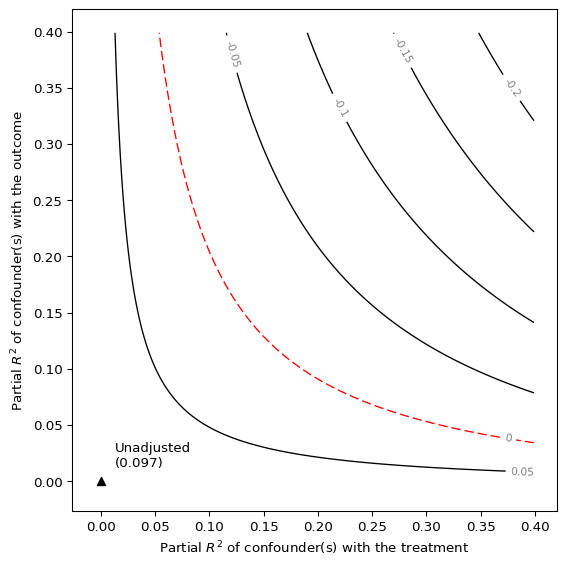

In [12]:
# contour plot of the point estimate
ovb_plots.ovb_contour_plot(estimate = 0.097, se = 0.023, dof = 783)

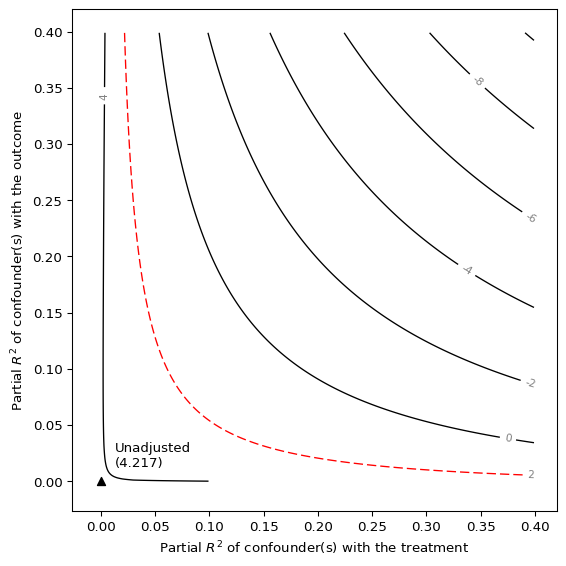

In [13]:
# contour plot of the t-value
ovb_plots.ovb_contour_plot(estimate = 0.097, se = 0.023, dof = 783, sensitivity_of="t-value")

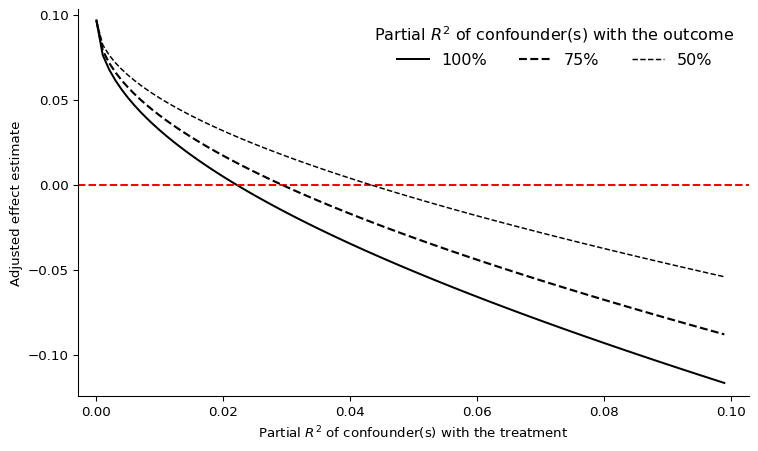

In [14]:
# extreme plot
ovb_plots.ovb_extreme_plot(estimate = 0.097, se = 0.023, dof = 783)

Finally, we show how users can compute bounds on the strength of confounding using only summary statistics, if the paper also provides a treatment regression table, i.e., a regression of the treatment on the observed covariates. Such regressions are sometimes shown in published works as part of efforts to describe the “determinants” of the treatment, or as “balance tests” in which the investigator assesses whether observed covariates predict treatment assigment. For the Darfur example, the regression coefficient and standard errors (in parenthesis) of `female` for the outcome and treatment equation are -0.097 (0.036) and -0.232 (0.024). With these, we can now compute the formal bounds as shown below.

In [30]:
# computes partial R2 based on t-value of female
r2yxj_dx = sensitivity_stats.partial_r2(t_statistic = -0.232/0.024, dof = 783)
r2dxj_x  = sensitivity_stats.partial_r2(t_statistic = -0.097/0.036, dof = 783)

# computes bounds on the strength of Z if it were 1, 2 or 3 times as strong as female
bounds   = ovb_bounds.ovb_partial_r2_bound(r2dxj_x = r2dxj_x,
                                           r2yxj_dx = r2yxj_dx,
                                           kd = [1,2,3],
                                           ky = [1,2,3], 
                                           benchmark_covariates="female")

bounds

,bound_label,r2dz_x,r2yz_dx
0,1x female,0.009272,0.121575
1,2x female,0.018544,0.243193
2,3x female,0.027816,0.364854


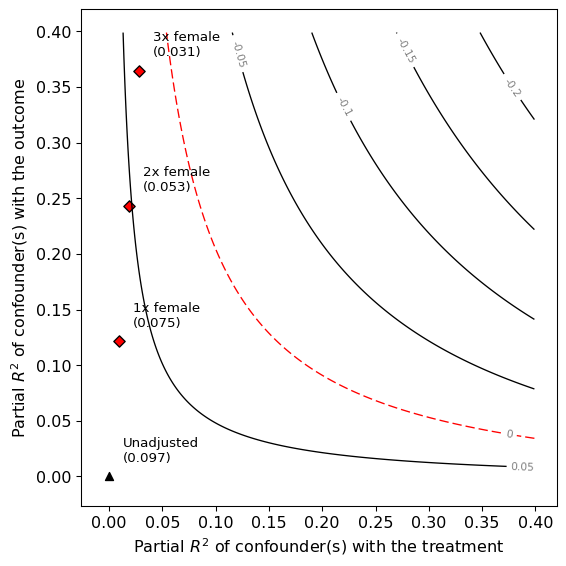

In [29]:
# computes adjusted estimate based on bounds
bound_values = bias_functions.adjusted_estimate(estimate = 0.0973, se = 0.0232, dof = 783, 
                                                r2dz_x= bounds['r2dz_x'], r2yz_dx=bounds['r2yz_dx'])

# draws contours
ovb_plots.ovb_contour_plot(estimate = 0.097, se = 0.023, dof = 783)

# adds bounds
ovb_plots.add_bound_to_contour(bounds = bounds, bound_value = bound_values)

## References

Cinelli, C. Hazlett, C. (2020) "Making Sense of Sensitivity: Extending Omitted Variable Bias". Journal of the Royal Statistical Society, Series B (Statistical Methodology). ( [link](https://doi.org/10.1111/rssb.12348) )